## 5.2 小さなデータセットでCNNを一から訓練する

今回の実例：<br>
<ul>
    <li>犬と猫の4,000枚の画像を使用する。
    <li>訓練データに2,000枚、検証データに1,000枚、テストデータに1,000枚とする。
    <li>犬と猫の２値分類問題をCNNを使って分類する！！
</ul>
全体の流れ：
<ol>
    <li>訓練データで小さなCNNを訓練（正則化なし）
    <li>過学習の抑制のため、データ拡張を実施（5.2.5） ←今回はここまで
    <li>学習済みのモデルによる特徴抽出(5.3)
    <li>学習済みモデルのファインチューニング(5.4)
</ol>

(参考)tensorflowでGPUの初期化ができない場合  
https://qiita.com/Ka-k/items/cb942855ab669ff60630

### 5.2.2 画像データの準備

In [1]:
# 元データのディレクトリパス設定
import os

# 実行が終わった時(エラー終了でも)は、メニューより Shut Down kernelを実行しなければ、
# GPU のメモリなど、確保したリソースが解放されないので、自分で実行する場合は要注意！！
# 実行後は、terminalでnvidia-smiコマンドを利用し、GPUメモリが開放されているか確認すべき。

# 使うGPUを指定（自分は1なので）
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ディレクトリ変数を設定
train_dir = './20200715/train_dir/'
validation_dir = './20200715/validation_dir/'
test_dir = './20200715/test_dir/'

# 各データのフォルダを設定
train_cats_dir = os.path.join(train_dir, 'train_cats_dir') 
validation_cats_dir = os.path.join(validation_dir, 'validation_cats_dir') 
test_cats_dir = os.path.join(test_dir, 'test_cats_dir') 
train_dogs_dir = os.path.join(train_dir, 'train_dogs_dir') 
validation_dogs_dir = os.path.join(validation_dir, 'validation_dogs_dir') 
test_dogs_dir = os.path.join(test_dir, 'test_dogs_dir') 

In [2]:
# 訓練・検証・テストデータの数を確認
print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(validation_cats_dir)))
print(len(os.listdir(test_cats_dir)))
print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(validation_dogs_dir)))
print(len(os.listdir(test_dogs_dir)))

1000
500
500
1000
500
500


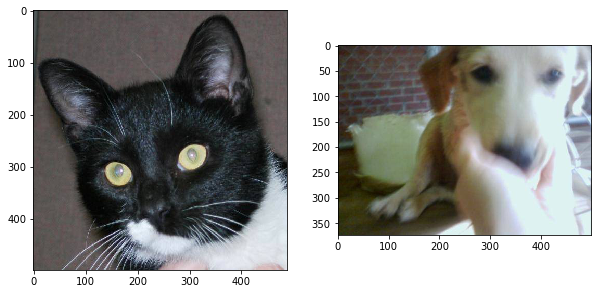

In [3]:
# 画像を確認してみる
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1_path = os.path.join(train_cats_dir, "cat.219.jpg")
img2_path = os.path.join(train_dogs_dir, "dog.219.jpg")

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(121)
ax1.imshow(img1)
ax2 = fig.add_subplot(122)
ax2.imshow(img2)

### 5.2.3 ネットワークの構築

In [4]:
# ネットワークの構築
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation="relu", input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [8]:
# オプティマイザ構築
from keras import optimizers
import keras

model.compile(loss="binary_crossentropy",
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=["acc"])

### 5.2.4 データの前処理

データをCNNへ供給する前に、データをfloat型のテンソルに変換する必要がある。画像データをCNNに渡す手順は以下のとおり。
<ol>
    <li>画像ファイルの読み込み
    <li>画像ファイルをRGBのピクセルグリッドにデコード
    <li>float型のテンソルへ変換
    <li>0〜255のピクセル値を0〜１へ正規化
</ol>
<em>Kerasでは、上記前処理を自動的に処理するユーティリティがあり、<p>
    preprosseing.imageモジュールの<b>ImageDataGeneratorクラス</b>を使う</em>

In [9]:
# ImageDataGeneratorの引数のデフォルト値
keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,               # データセット全体の平均を使ってを０にするか
    samplewise_center=False,                # 各サンプルの平均を使って０にするか
    featurewise_std_normalization=False,    # データセット全体の標準偏差で正規化するか
    samplewise_std_normalization=False,     # 各サンプルの標準偏差で正規化するか
    zca_whitening=False,                    # 白色化するか
    zca_epsilon=1e-06,                      # 白色化する際のεの値
    rotation_range=0.0,                     # 画像をランダムに回転させる範囲
    width_shift_range=0.0,                  # ランダムに水平シフトする範囲
    height_shift_range=0.0,                 # ランダムに垂直シフトする範囲
    brightness_range=None,                  # ランダムに画像の明るさを変更する範囲
    shear_range=0.0,                        # ランダムに剪断（歪み）させる角度の範囲
    zoom_range=0.0,                         # ランダムに拡大縮小の範囲
    channel_shift_range=0.0,                # ランダムに各チャンネルの画素値に値を加減する範囲
    fill_mode='nearest',                    # 入力画像の周りを埋める方法{"constant", "nearest", "reflect", "wrap"}がある。
    cval=0.0,                               # fill_mode = "constant"のときに利用される値
    horizontal_flip=False,                  # 水平方向に入力をランダムに反転させるかどうか（左右逆）
    vertical_flip=False,                    # 垂直方向に入力をランダムに反転させるかどうか（上下逆）
    rescale=None,                           # リスケーリングする際の乗数
    preprocessing_function=None,            # 各入力に適用される関数をここで設定できる
    data_format=None,                       # {"channels_first", "channels_last"}のどちらか。デフォルトは、channels_lastで
                                            # (samples, height, width, channels)の形になる
    validation_split=0.0)                   # 検証データの割合(train_test_split的な)

In [10]:
#ImageDataGeneratorクラスのflow_from_directoryメソッドの引数のデフォルト値
ImageDataGenerator.flow_from_directory(
    directory,                 # ディレクトリへのパス。クラスごとに1つのサブディレクトリを含み，サブディレクトリはPNGかJPGかBMPかPPMかTIF形式の画像を含まなければいけない
    target_size=(256, 256),    # 指定した値に全画像がリサイズされる
    color_mode='rgb',          # "grayscale"か"rbg"のどちらか。デフォルトは"rgb"。
    classes=None,              # クラスサブディレクトリのリスト
    class_mode='categorical',  # 返すラベルの配列のshapeを決定する。{"categorical"か"binary"か"sparse"か"input"か"None"}のどれか
                               # "categorical"は2次元のone-hotラベル， "binary"は1次元の2値ラベル， "sparse"は1次元の整数ラベル， "input"は入力画像と同じ画像
    batch_size=32,             # バッチサイズ
    shuffle=True,              # データのシャッフルフラグ
    seed=None,                 # 乱数のシード
    save_to_dir=None,          # 生成された画像の保存ディレクトリパスを指定
    save_prefix='',            # 画像を保存する際のprefix指定
    save_format='png',         # "png"または"jpeg"（save_to_dirの引数に何か入力されている場合のみ有効）
    follow_links=False,        # サブディレクトリ内のシンボリックリンクに従うかどうか
    subset=None,               # データのサブセット（"training"か"validation") ImageDataGeneratorでvalidation_splitが与えられた場合に指定する。
    interpolation='nearest')   # 画像の補完方法 "nearest"か"bilinear"か"bicubic"

NameError: name 'ImageDataGenerator' is not defined

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# ピクセル値の最大値255で割ることで、各ピクセル値を0〜１の値に
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# 訓練データのジェネレータ作成
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

# 検証データのジェネレータ作成
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
# ジェネレータから生成される各データのshapeを確認
for data_batch, label_batch in train_generator:
    print(data_batch.shape)
    print(label_batch.shape)
    break

(20, 150, 150, 3)
(20,)


<li>ジェネレータを利用して学習を行うには、modelオブジェクトの<b>fit_generator</b>メソッドを使用する。

In [13]:
# fit_generatorメソッドの引数のデフォルト値
fit_generator(
    generator,                  # 訓練用データのジェネレータ
    steps_per_epoch=None,       # 次のepochに行くまでのジェネレータ呼び出し回数（forループ何回回すか）
    epochs=1,                   # epoch数
    verbose=1,                  # 学習進行状況の表示フラグ 0 = 表示なし， 1 = プログレスバー， 2 = 各試行毎に一行の出力．
    callbacks=None,             # 訓練時に呼ばれるコールバックのリスト
    validation_data=None,       # バリデーション用データのジェネレータ
    validation_steps=None,      # 次のepochに行くまでのジェネレータ呼び出し回数（forループ何回回すか）
    class_weight=None,          # 損失関数の重み付けに使われるらしい？？
    max_queue_size=10,          # ジェネレータのキューのための最大サイズ
    workers=1,                  # スレッドベースのプロセス使用時の最大プロセス数
    use_multiprocessing=False,  # Trueならスレッドベースのプロセスを使う
    shuffle=True,               # 各試行の初めにバッチの順番をシャッフルするかどうか
    initial_epoch=0)            # 学習を開始するエポック（前回の学習を再開するのに便利）

NameError: name 'fit_generator' is not defined

In [ ]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/30
100/100 [==============================] - 22s 223ms/step - loss: 0.6932 - acc: 0.5235 - val_loss: 0.6389 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 38s 378ms/step - loss: 0.6634 - acc: 0.6025 - val_loss: 0.6117 - val_acc: 0.6410
Epoch 3/30
 28/100 [=======>......................] - ETA: 13s - loss: 0.6328 - acc: 0.6500

In [ ]:
# モデルを保存
model.save("cats_and_dogs_small_1.h5")

In [ ]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# 正解率をプロット
fig = plt.figure(figsize=(25,8))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc, "bo", label="Training acc")
ax1.plot(epochs, val_acc, "b-", label="Validation acc")
ax1.set_title("Training and validation accuracy")
ax1.legend()

# 損失値をプロット
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss, "ro", label="Training loss")
ax2.plot(epochs, val_loss, "r-", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()

（左図）
訓練データでの正解率は100%近くに達しているが、検証データでの正解率は70%程度で頭打ちしている。→過学習の兆候！！

（右図）
訓練データでの損失値はepochを増やすにつれて、０に近づいていっているが、一方検証データでは、0.3辺りで止まり、乱高下を繰り返して不安定である。

### 5.2.5 データ拡張

データ拡張とは、既存の訓練サンプルからさらに訓練データを生成するというアプローチであり、  
ランダムな変換をいくつか実行し、それっぽい画像を生成することで、サンプルを水増しする。

<b>Kerasで実行するには、ImageDataGeneratorクラスをインスタンス化する際に、ランダムな変換を設定する！！</b>

In [ ]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode="nearest")

In [ ]:
# データ拡張のサンプル
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# 水増し画像を選択
img_path = fnames[3]

# 画像を読み込みサイズを変更
img = image.load_img(img_path, target_size=(150, 150))

# Numpy配列に置換
x = image.img_to_array(img)

# （1, 150, 150, 3）の形状に変形
x = x.reshape((1,) + x.shape)

# ランダムに変換した画像のバッチを生成する。
# 無限ループとなってしまうため、４枚取得したところループを抜ける
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

作成した拡張データを用いてCNNを訓練する場合、拡張したデータは元からあるデータと全く同じデータではないため、同じ画像を２回訓練することにはならないが、  
元からあるデータを少し変えただけのデータであるので、入力データの相関性は高いままとなってしまう。

→ 過学習を少しでも減らすため、Dropout層を追加した新しいネットワークを作成する！！

In [ ]:
# 新しいネットワーク作成
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation="relu", input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))                   # ドロップアウト層を追加
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=["acc"])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# 訓練データのジェネレータ作成
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

# 検証データのジェネレータ作成
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
model.save("cats_and_dogs_small_2.h5")

In [ ]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# 正解率をプロット
fig = plt.figure(figsize=(25,8))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc, "bo", label="Training acc")
ax1.plot(epochs, val_acc, "b-", label="Validation acc")
ax1.set_title("Training and validation accuracy")
ax1.legend()

# 損失値をプロット
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss, "ro", label="Training loss")
ax2.plot(epochs, val_loss, "r-", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()

データ拡張とドロップアウト層を追加したことで、過学習が抑えられており、学習曲線と検証曲線が同じように動いている。  
正解率も80%程度と、前回よりも向上している。